# Data Immersion Task 6.6

# Contents

1. Import libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis
4. Testing for stationarity
5. Stationarizing the data

I chose this data because I believe I can link it to my project. One of the key factors to a country's Happiness Score is economy. This dataset looks at the estimate of the output the United States economy would produce with a high rate of use of its resources. This ties into my project because I want to know just how much economy influences happiness, as well as what policies a country can implement to increase overall happiness.

# 1. Import libraries and data

In [1]:
#Import data libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#Configure API key

quandl.ApiConfig.api_key = 'Be4LEstmdU1Vwy7NAy8x'

In [3]:
#Importing the Federal Reserve Economic Data/Real Potential Gross Domestic Product

data = quandl.get('FRED/GDPPOT')

In [4]:
data.head()

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

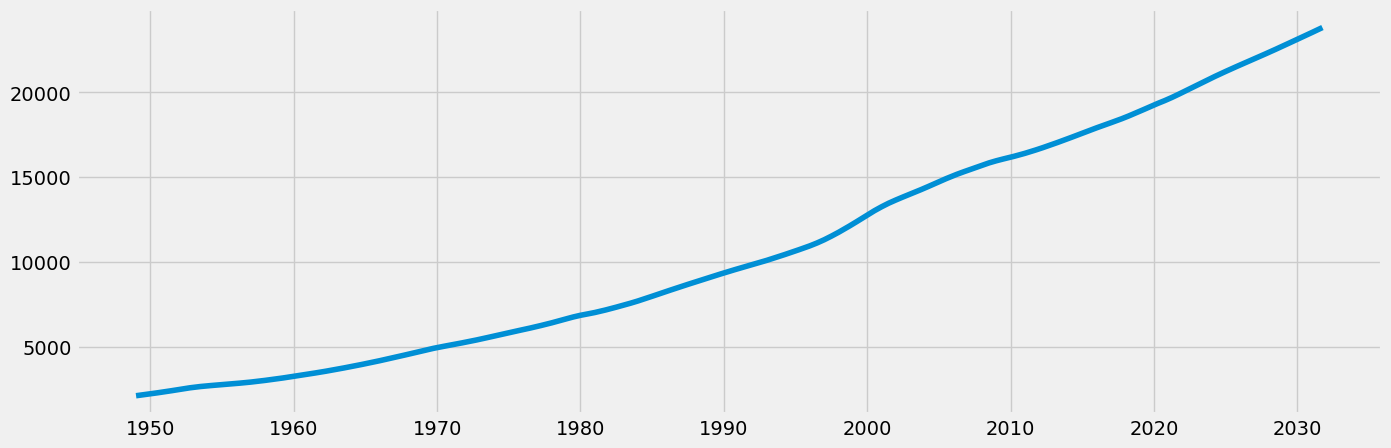

In [7]:
#Plot the data on a line chart using matplotlib

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data 

In [8]:
#Reset the index of the dataframe

data_2 = data.reset_index()

In [9]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [10]:
data_2.tail()

,Date,Value
327,2030-10-01,23423.37
328,2031-01-01,23522.55
329,2031-04-01,23622.05
330,2031-07-01,23721.65
331,2031-10-01,23821.31


In [11]:
#Create subset of the data to eliminate any forecasted data

data_sub = data_2.loc[(data_2['Date'] >= '1949-01-01') & (data_2['Date'] < '2023-01-01')]

In [12]:
data_sub.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [13]:
data_sub.tail()

,Date,Value
291,2021-10-01,19898.25
292,2022-01-01,20003.73
293,2022-04-01,20109.88
294,2022-07-01,20216.09
295,2022-10-01,20321.48


In [14]:
#Setting the date as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) #Create datetime column from 'Date'
data_sub = data_sub.set_index('datetime') #Set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) #Drop the 'Date' column
data_sub.head()

,Value
datetime,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


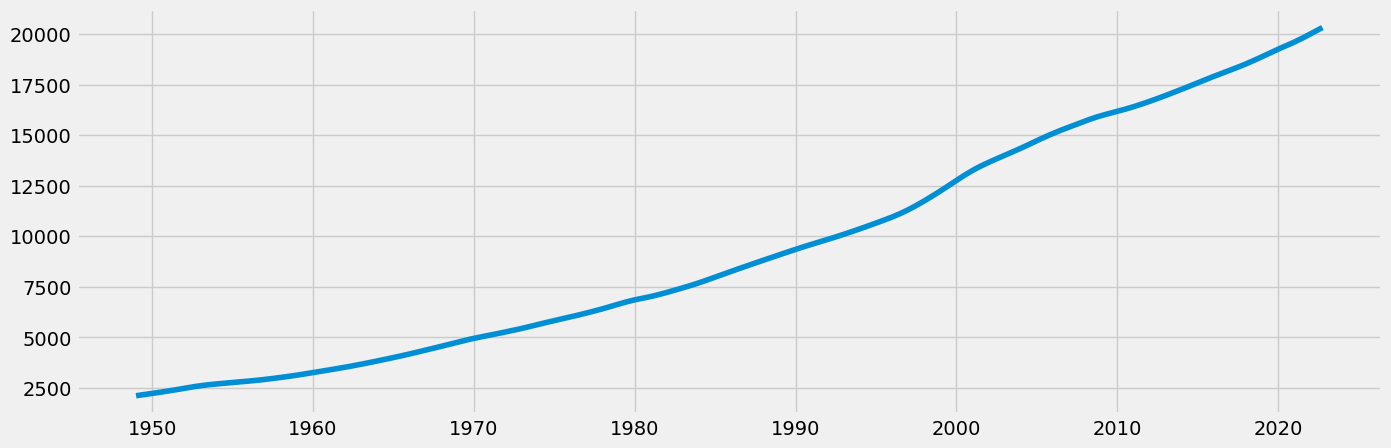

In [15]:
#Plot the new data on a line chart using matplotlib

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
#Check for missing values

data_sub.isnull().sum()

Value    0
dtype: int64

No missing values found.

In [17]:
#Check for duplicates

data_dups = data_sub[data_sub.duplicated()]

In [18]:
data_dups

,Value
datetime,


No duplicates found.

# 3. Time series analysis

In [19]:
#Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
#Define a fixed size for all special charts

from pylab import rcParams

In [21]:
rcParams['figure.figsize'] = 18, 7

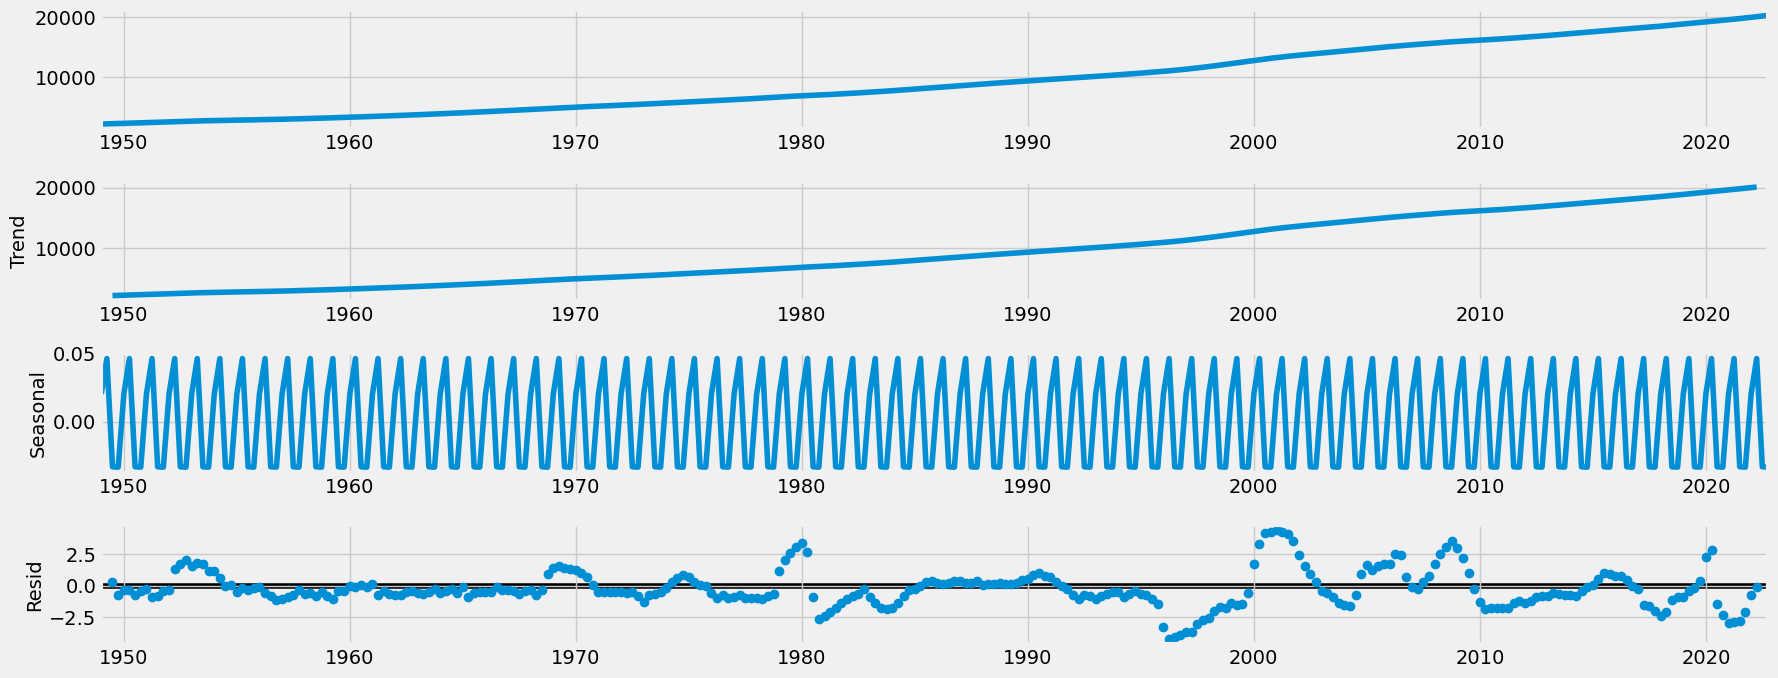

In [22]:
#Plot the separate components

decomposition.plot()
plt.show()

Because the level and the trend are the same, this data is already smooth. The data has been steadily climbing since 1950 to 2022. The third section shows that the data does have seasonality since it has spikes. If the data didn't have any seasonality, the curve would be flat. In the residual section, there are definitely some time periods where it is not consistent. There is consistency from 1950-1995 with a few changes happening around the mid 1950s, 1970, and 1980. The largest fluctuations start occurring around 1995 and remain inconsistent until 2022. The reason for this could be years where the United States had economic struggles or recessions, but more research would need to be done to confirm.

# 4. Testing for stationarity

In [23]:
#Import the adfuller() function

from statsmodels.tsa.stattools import adfuller

In [24]:
def dickey_fuller(timeseries): #Define the function
    #Perform the Dickey-Fuller test:
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [25]:
#Apply the test using the function on the time series

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.925861
p-value                          0.998569
Number of Lags Used              5.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64


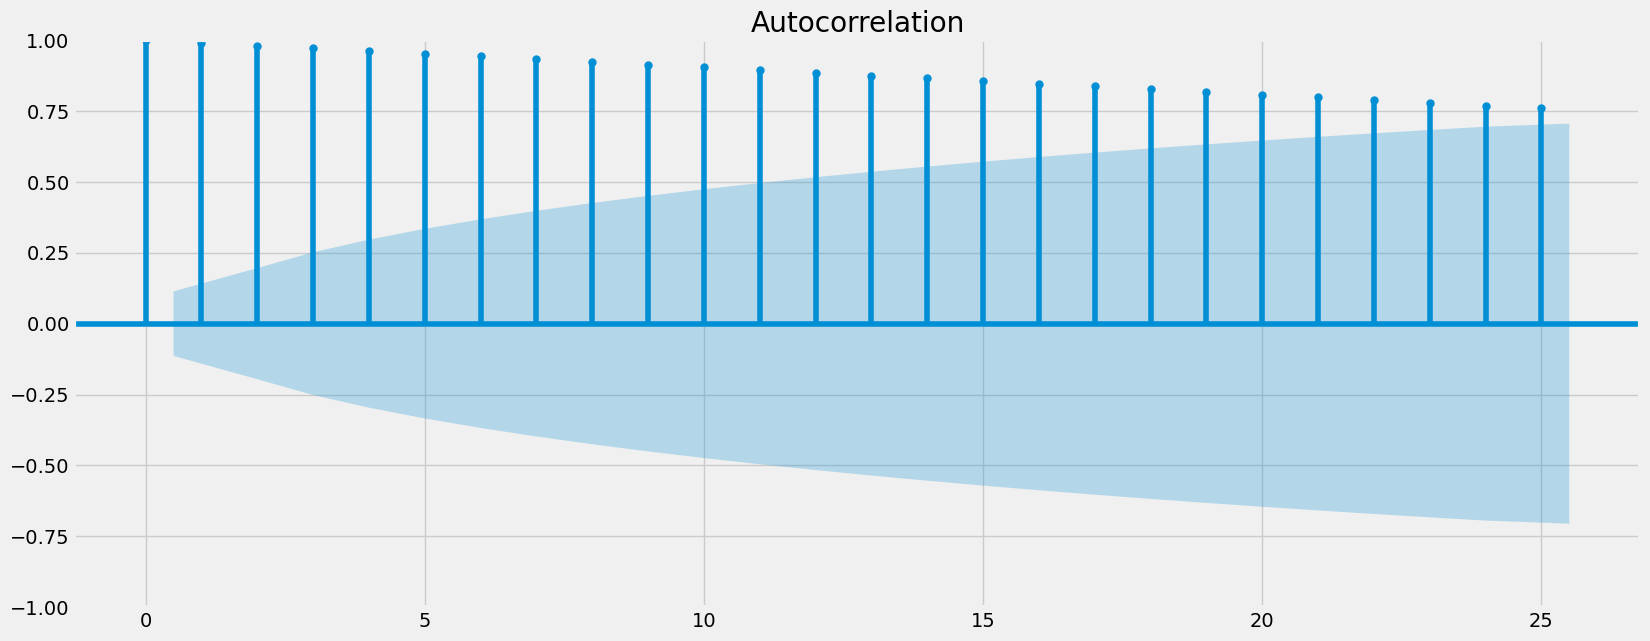

In [26]:
#Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(data_sub)
plt.show()

The Critical Value (5%) is significantly smaller than the Test Statistic, and in the graph the lines go above the blue confidence interval. This means that the data is non-stationary so we will have to make it stationary.

# 5. Stationarizing the data

In [27]:
#Differencing

data_diff = data_sub - data_sub.shift(1) 

In [28]:
#Remove missing values that were a result of the differencing

data_diff.dropna(inplace = True)

In [29]:
#Re-run the Dickey-Fuller test

def dickey_fuller(timeseries): #Define the function
    #Perform the Dickey-Fuller test:
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [30]:
#Apply the test using the function on the time series

dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.420723
p-value                          0.572302
Number of Lags Used              5.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


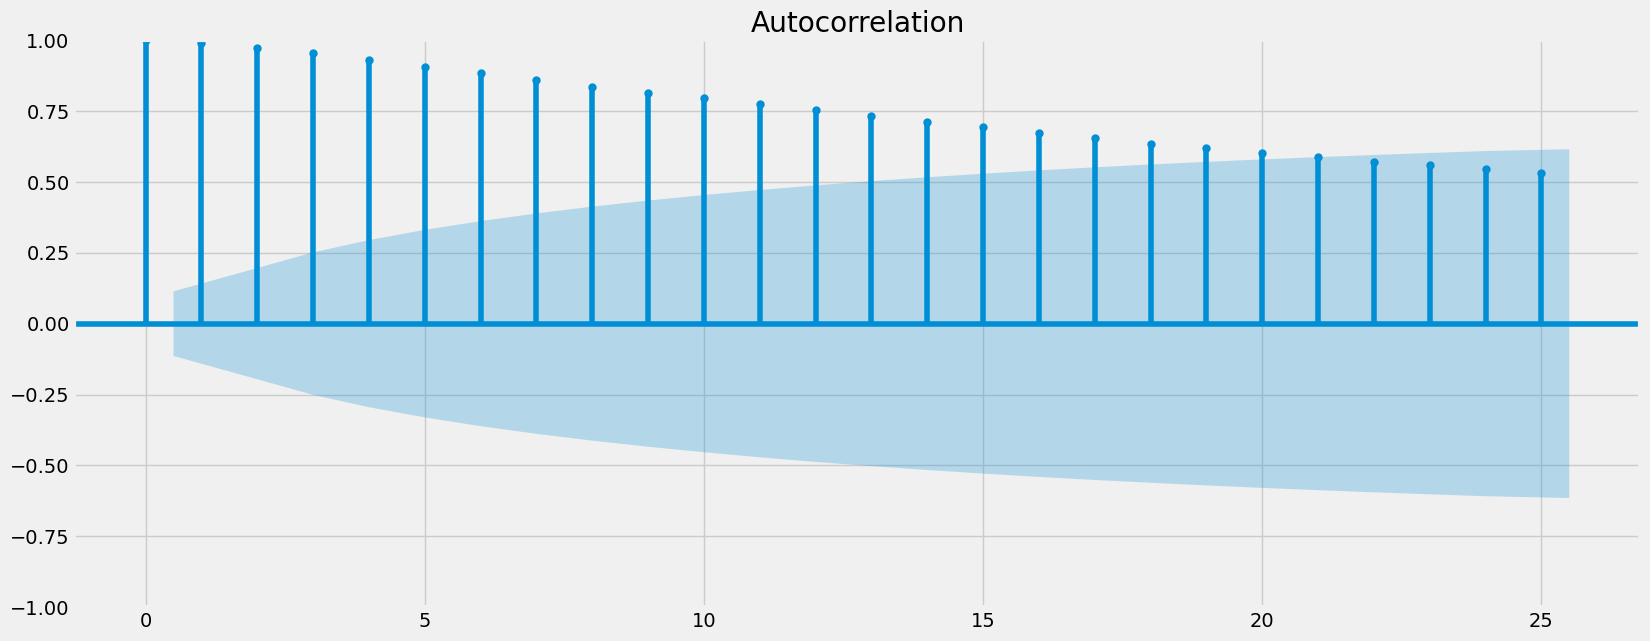

In [31]:
#Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(data_diff)
plt.show()

In [32]:
#Complete another round of differencing

data_diff2 = data_diff - data_diff.shift(1)

In [33]:
#Remove missing values that were a result of the differencing

data_diff2.dropna(inplace = True)

In [34]:
#Apply the test using the function on the time series

dickey_fuller(data_diff2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.214720e+00
p-value                        5.400614e-08
Number of Lags Used            3.000000e+00
Number of Observations Used    2.900000e+02
Critical Value (1%)           -3.453102e+00
Critical Value (5%)           -2.871559e+00
Critical Value (10%)          -2.572108e+00
dtype: float64


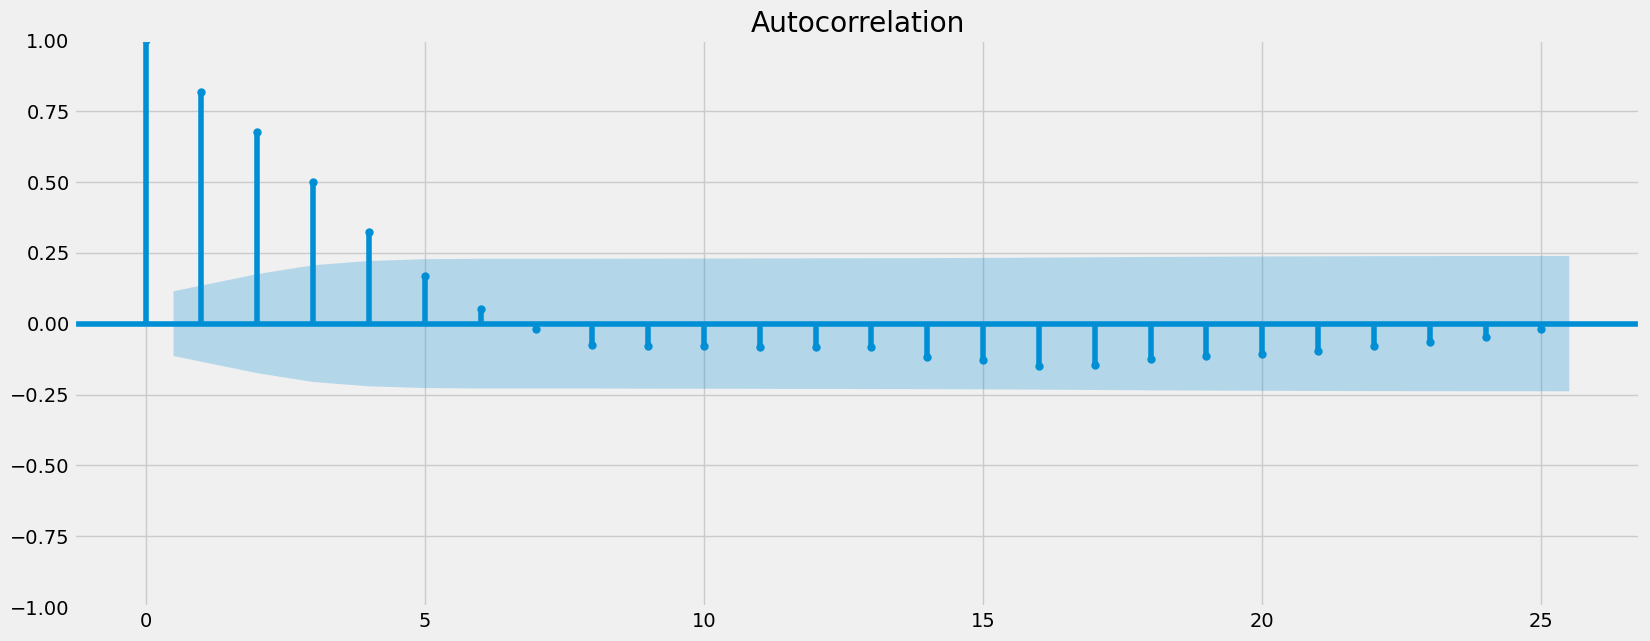

In [35]:
#Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(data_diff2)
plt.show()

The data is now considered stationary, as the Test Statistic is now smaller than the Critical Value at both 5% and 10%. There are fewer than 10 significant lags so no further differencing is necessary.